In [1]:
import random

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils import data
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision.utils as vutils
from torchvision.utils import make_grid
import os

import scipy.io

from sklearn.model_selection import train_test_split
from tqdm import tqdm

from classify_svhn import *

## Models

In [2]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=256):
        return input.view(input.size(0), size, 4, 4)


# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input size is 3x32x32
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1,bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size = 32x32x32
            nn.Conv2d(32, 64, 4,2,1,bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # state size = 64x16x16
            nn.Conv2d(64, 256, 4, 2, 1,bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # state size = 256 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1,bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # state size = 512 x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0,bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # state size. 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # state size. 256 x 8 x 8
            nn.ConvTranspose2d(256, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 16 x 16
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # state size. 32 x 32 x 32
            nn.ConvTranspose2d(32, 3, 3, 1, 1, bias=False),
            nn.Tanh()
            # state size. 3 x 32 x 32
        )

    def forward(self, input):
        return self.main(input)


class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=256, z_dim=100):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            
            # input size is 3x32x32
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1,bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size = 32x32x32
            nn.Conv2d(32, 64, 4, 2, 1,bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # state size = 64x16x16
            nn.Conv2d(64, 256, 4, 2, 1,bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # state size = 256 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1,bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # state size = 512 x 4 x 4
            nn.Conv2d(512, 256, 4, 1, 0,bias=False),
            # state size = 1024 x 1 x 1
            
        )
        
        self.flat = Flatten()
        self.unflat = UnFlatten()
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            
            # input is Z, going into a convolution
            nn.ConvTranspose2d(256, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # state size. 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # state size. 256 x 8 x 8
            nn.ConvTranspose2d(256, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 16 x 16
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # state size. 32 x 32 x 32
            nn.ConvTranspose2d(32, 3, 3, 1, 1, bias=False),
            nn.Tanh()
            # state size. 3 x 32 x 32
        )
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
#         print(h.size())
        h = self.flat(h)
#         print(h.size())
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
 
        z = self.fc3(z)
#         print(z.size())
        z = z.view([z.size(0), 256, 1, 1])
#         print(z.size())
        z = self.decoder(z)
#         print(z.size())
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

## load models

In [6]:
# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device used: ", device)

#LOAD VAE
model_vae = VAE()
model_vae.load_state_dict(torch.load('vae.torch'))
model_vae.to(device)
model_vae.eval()

#LOAD GAN GENERATOR
model_gen = Generator()
model_gen.load_state_dict(torch.load('gan_gen.torch'))
model_gen.to(device)
model_gen.eval()

#LOAD GAN DISCRIMINATOR
model_dis = Discriminator()
model_dis.load_state_dict(torch.load('gan_dis.torch'))
model_dis.to(device)
model_dis.eval()

Device used:  cuda:0


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(64, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

## 3.1 qualitatif

In [7]:
def show(img,figname,path):

    npimg = img.numpy()
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest', aspect='auto')
    plt.tight_layout()
    plt.savefig(os.path.join(path, figname),dpi=300)

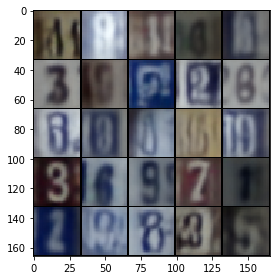

In [9]:
#generate VAE (25 images grid 5x5)
img_path="./"
noise = torch.randn(25, 100, device=device)
fake = model_vae.decode(noise)
fake = fake.detach().cpu()
show(make_grid(fake, padding=1,normalize=True,nrow=5),"vae_gen_25",img_path)


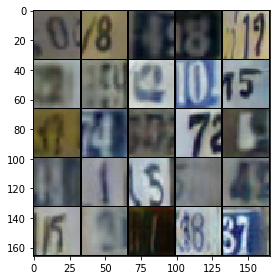

In [11]:
#generate GAN (25 images grid 5x5)
img_path="./"
noise = torch.randn(25, 100, 1, 1, device=device)
fake = model_gen(noise)
fake = fake.detach().cpu()
show(make_grid(fake, padding=1,normalize=True,nrow=5),"gan_gen_25",img_path)